In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import constants as const
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.coordinates import SkyCoord
from astropy import units as u

plt.rcParams["xtick.major.size"] = 9
plt.rcParams["xtick.major.width"] = 1.5
plt.rcParams["ytick.major.size"] = 9
plt.rcParams["ytick.major.width"] = 1.5
plt.rcParams["font.size"] = 14

pi = np.pi
BIGG = const.G.value
MSUN = const.M_sun.value
AU = const.au.value
OUMUAMUA_COORDS = [np.radians(279.804-360.), np.radians(33.997)]

THETA = np.radians(122.932)                    
ANGP = np.radians(192.859508)
DNGP = np.radians(27.128336)

In [2]:
LAT = np.radians(-30.-(14./60.)-(40.68/3600.))
LONG = np.radians(-70.-(44./60.)-(57.90/3600.))

INIT_TIME = '2021-01-01 00:00'
t0 = Time(INIT_TIME, scale='utc', location=(LAT, LONG))

# Read in text files

In [3]:
MAINPATH = 'distribution_function/'
vel = np.loadtxt(MAINPATH + 'vgal.txt')           # already galactic velocities, with respect to Sun             
                                                  # subtracting VSUN is unecessary
NSAMPLES = len(vel)

In [4]:
T1 = [[np.cos(THETA), np.sin(THETA), 0.], [np.sin(THETA), -np.cos(THETA), 0.], [0., 0., 1.]]    
T2 = [[-np.sin(DNGP), 0., np.cos(DNGP)], [0., 1., 0.], [np.cos(DNGP), 0., np.sin(DNGP)]]        
T3 = [[np.cos(ANGP), np.sin(ANGP), 0.], [-np.sin(ANGP), np.cos(ANGP), 0.], [0., 0., 1.]]

T = np.matmul(np.matmul(T1, T2), T3)                                                       
                                                                                           
def get_ra_dec(R):
    R = np.matmul(np.linalg.inv(T), R)
    mag = np.linalg.norm(R)
    dec = np.arcsin(R[2]/mag)
    if R[1]/mag > 0:
        ra = np.arccos(R[0]/(mag*np.cos(dec)))
    else:
        ra = 2*pi-np.arccos(R[0]/(mag*np.cos(dec)))
    if ra > pi:
        ra = ra - 2*pi
    return np.asarray([ra, dec])

pos = np.zeros((NSAMPLES, 2))
for i, v in enumerate(vel):
    pos[i] = get_ra_dec(-v)           

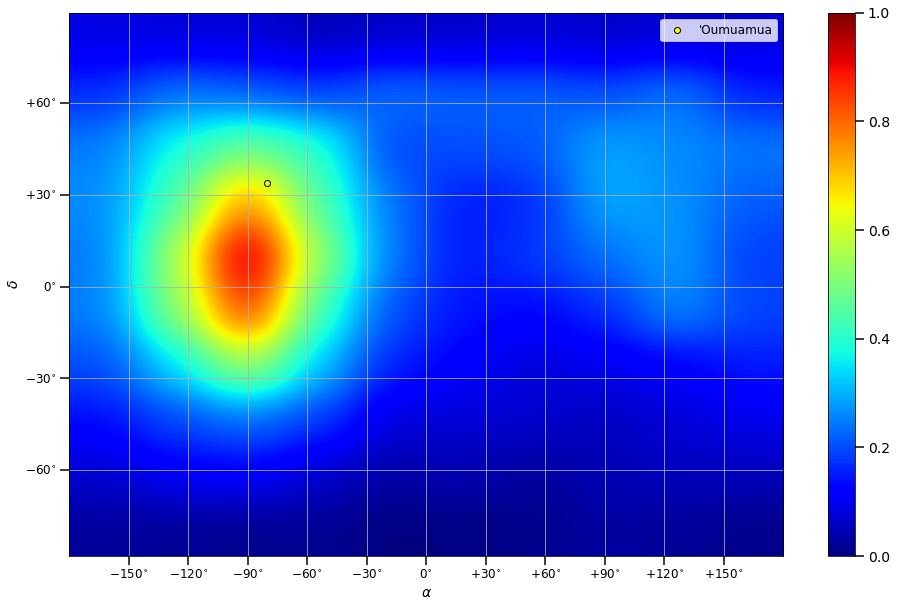

In [5]:
plt.figure(figsize=(16, 10))

H, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=10)
plt.imshow(H.transpose()[::-1], extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='gaussian', aspect='auto', \
           cmap='jet')

plt.xlabel(r'$\alpha$')
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          fontsize=12)

plt.ylabel(r'$\delta$')
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)

plt.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', label="'Oumuamua")
plt.legend(loc='upper right', fontsize=12)
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='jet'))

plt.show()

# Draw b and $\psi$

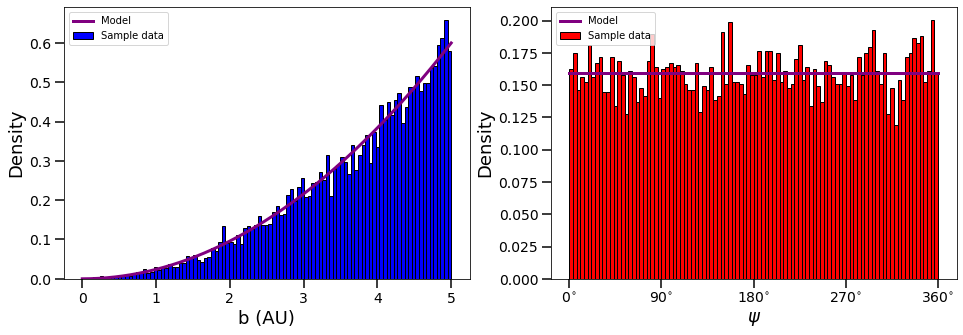

In [6]:
A = 0.                                                     
B = 5.

def sample_b_dist(N=NSAMPLES, a=0, b=5):                  
    P = np.random.uniform(size=N)
    return (P*(b**3-a**3) + a**3)**(1/3)

b = sample_b_dist(a=A, b=B)
psi = np.random.uniform(low=0, high=2*pi, size=NSAMPLES)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax1 = axes[0]
ax1.hist(b, color='blue', edgecolor='k', bins=100, density=True, label='Sample data')
x = np.linspace(A, B, 1000)
ax1.plot(x, 3*x**2/(B**3-A**3), c='purple', lw=3, label='Model')                         
ax1.set_xlabel('b (AU)', fontsize=18)
ax1.set_ylabel('Density', fontsize=18)
ax1.legend(loc='upper left', fontsize=10)

ax2 = axes[1]
ax2.hist(psi, color='red', edgecolor='k', bins=100, density=True, label='Sample data')
ax2.plot(np.linspace(0, 2*pi, 1000), np.repeat([1/(2*pi)], 1000), c='purple', lw=3, label='Model')  
ax2.set_xlabel(r'$\psi$', fontsize=18)
ax2.set_xticks([0, pi/2, pi, 3*pi/2, 2*pi])
ax2.set_xticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$', r'$270^{\circ}$', r'$360^{\circ}$'])
ax2.set_ylabel('Density', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)

plt.savefig('figures/b_psi.pdf', bbox_inches='tight', dpi=250)
plt.show()

# Get initial R vectors

In [7]:
RSKY = 5. 
VESC = np.sqrt(2*BIGG*MSUN/(RSKY*AU))/1000

for i, v in enumerate(vel):
    vel[i] = v*np.sqrt(np.linalg.norm(v)**2 + \
                       VESC**2)/np.linalg.norm(v)

In [8]:
R = np.zeros((NSAMPLES, 3))
b_vec = np.zeros_like(R)
R_sky = np.zeros_like(R)

for i, v in enumerate(vel):
    R_sky[i] = -np.sqrt(RSKY**2-b[i]**2)*v/np.linalg.norm(v)
    phi = np.arctan(-(np.cos(psi[i])*v[0] + np.sin(psi[i])*v[1])/v[2])
    b_vec[i] = np.array([b[i]*np.cos(phi)*np.cos(psi[i]), b[i]*np.cos(phi)*np.sin(psi[i]), \
                         b[i]*np.sin(phi)])
    R[i] = R_sky[i] + b_vec[i]

# Run simulations using REBOUND

In [9]:
import rebound

NTIMES = 100
INTEGRATION_TIME = 3.*365.*24.*60.*60. 

sim = rebound.Simulation()
sim.units = ('s', 'AU', 'kg')
sim.add(['Sun', 'Earth'], date=INIT_TIME)
sim.save('ss.bin') 

def plot_orbit(R, v):
    sim = rebound.Simulation('ss.bin')
    sim.add(x=R[0], y=R[1], z=R[2], vx=v[0]*1000./AU, \
            vy=v[1]*1000./AU, vz=v[2]*1000./AU)
    rebound.OrbitPlot(sim, periastron=True, color=True, \
            unitlabel='[AU]', slices=0.5, orbit_type='solid')
    
def get_apparent_magnitude(dBS, dBO, dOS, H=22.4):
    theta = np.arccos((dBO**2 + dBS**2 - dOS**2)/(2*dBO*dBS))
    phase = (2/3)*((1-theta/pi)*np.cos(theta) + np.sin(theta)/pi)
    
    m = H + 2.5*np.log10((dBS**2*dBO**2)/(phase*dOS**4))
    return m

def integrate(R, v):
    sim = rebound.Simulation('ss.bin')
    sim.add(x=R[0], y=R[1], z=R[2], vx=v[0]*1000./AU, \
            vy=v[1]*1000./AU, vz=v[2]*1000./AU)
    
    ps = sim.particles
    times = np.linspace(0, INTEGRATION_TIME, NTIMES)
    distances = np.zeros_like(times)
    mag = np.zeros_like(times)
    
    rad = np.zeros((NTIMES, 3))
    vel = np.zeros_like(rad)
    
    pos_eq = np.zeros((NTIMES, 2))
    solar_pos_eq = np.zeros_like(pos_eq)
    
    orbit = ps[-1].calculate_orbit(primary=ps[0])
    
    for i, t in enumerate(times):
        sim.integrate(t)
        
        rBS = ps[2] - ps[0]
        rBO = ps[2] - ps[1]
        rOS = ps[1] - ps[0]
        
        dBS = np.sqrt(rBS.x**2 + rBS.y**2 + rBS.z**2)
        dBO = np.sqrt(rBO.x**2 + rBO.y**2 + rBO.z**2)
        dOS = np.sqrt(rOS.x**2 + rOS.y**2 + rOS.z**2)
        
        distances[i] = dBO
        rad[i] = np.array([ps[-1].x, ps[-1].y, ps[-1].z])
        vel[i] = np.array([ps[-1].vx, ps[-1].vy, ps[-1].vz])
        mag[i] = get_apparent_magnitude(dBS, dBO, dOS)
        pos_eq[i] = get_ra_dec(rad[i])
        solar_pos_eq[i] = get_ra_dec([-rOS.x, -rOS.y, -rOS.z])
        
    orbit_data = {}
    orbit_data['times'] = times
    orbit_data['dist'] = distances
    orbit_data['rad'] = rad
    orbit_data['vel'] = vel
    orbit_data['mag'] = mag
    orbit_data['pos_eq'] = pos_eq
    orbit_data['solar_pos_eq'] = solar_pos_eq
    
    orbit_data['a'] = orbit.a
    orbit_data['e'] = orbit.e
    orbit_data['inc'] = orbit.inc
    orbit_data['Omega'] = orbit.Omega
    orbit_data['omega'] = orbit.omega
    orbit_data['f'] = orbit.f
    
    return orbit_data 

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Earth'... Found: Target body name: Earth-Moon Barycenter (3).


In [10]:
def plot_cdf(arr, name=None, xlabel=None, color=None):
    x = np.sort(np.squeeze(arr))
    plt.plot(x, np.linspace(0, 1, len(arr)), lw=2, c=color)
    
    plt.xlabel(xlabel)
    plt.xlim(min(x), max(x))
    
    plt.ylabel(r'$cdf$')
    plt.ylim(0, 1)
    
    if name is not None:
        plt.savefig('figures/' + name + '.pdf', bbox_inches='tight', \
                    dpi=250)
    
    plt.show()
    
def plot_hist(data, bins='auto', c=None, label=None, alpha=0.65, \
              lw=2.5, histtype='step', weights=None, name=None):
    plt.hist(data, bins=bins, color=c, alpha=alpha, label=label, \
             weights=weights)
    plt.hist(data, bins=bins, edgecolor=c, fill=None, \
             histtype=histtype, lw=lw, label=label, weights=weights)
    plt.xlabel(label)
    plt.ylabel(r'$N$')
    
    if name is not None:
        plt.savefig('figures/' + name + '.pdf', bbox_inches='tight', \
                    dpi=250)
        
    plt.show()

In [11]:
orbits = {}

orbits['a'] = np.zeros(NSAMPLES)
orbits['e'] = np.zeros_like(orbits['a'])
orbits['inc'] = np.zeros_like(orbits['a'])
orbits['Omega'] = np.zeros_like(orbits['a'])
orbits['omega'] = np.zeros_like(orbits['a'])
orbits['f'] = np.zeros_like(orbits['a'])
orbits['b'] = np.zeros_like(orbits['a'])

orbits['dist'] = np.zeros((NSAMPLES, NTIMES))
orbits['mag'] = np.zeros_like(orbits['dist'])
orbits['times'] = np.zeros_like(orbits['dist'])

orbits['rad'] = np.zeros((NSAMPLES, NTIMES, 3))
orbits['vel'] = np.zeros_like(orbits['rad'])

orbits['pos_eq'] = np.zeros((NSAMPLES, NTIMES, 2))
orbits['solar_pos_eq'] = np.zeros_like(orbits['pos_eq'])

for i in range(NSAMPLES):
    if i % 2500 == 0:
        print(i)
    o = integrate(R[i], vel[i])
    
    orbits['a'][i] = o['a']
    orbits['e'][i] = o['e']
    orbits['inc'][i] = o['inc']
    orbits['Omega'][i] = o['Omega']
    orbits['omega'][i] = o['omega']
    orbits['f'][i] = o['f']
    orbits['b'][i] = b[i]
    
    orbits['dist'][i] = o['dist']
    orbits['mag'][i] = o['mag']
    orbits['rad'][i] = o['rad']
    orbits['vel'][i] = o['vel']
    orbits['pos_eq'][i] = o['pos_eq']
    orbits['solar_pos_eq'][i] = o['solar_pos_eq']
    orbits['times'][i] = o['times']

0
2500
5000
7500


In [12]:
orbits['sid_time'] = np.zeros_like(orbits['times'])
orbits['datetime'] = np.zeros((NSAMPLES, NTIMES, 3))
for i in range(NTIMES):
    dt = TimeDelta(orbits['times'][:, i], format='sec')
    t1 = t0 + dt
    orbits['sid_time'][:, i] = t1.sidereal_time('apparent').to(u.radian).value
    orbits['datetime'][:, i, 0] = t1.ymdhms.year
    orbits['datetime'][:, i, 1] = t1.ymdhms.month
    orbits['datetime'][:, i, 2] = t1.ymdhms.day

In [13]:
def get_az_alt(pos, sid_time):
    alt = np.arcsin(np.sin(pos[:, 1])*np.sin(LAT) + \
                np.cos(pos[:, 1])*np.cos(LAT)*np.cos(sid_time-pos[:, 0]))
    az = np.arcsin(-np.sin(sid_time-pos[:, 0])*np.cos(pos[:, 1])/np.cos(alt))
    return np.column_stack((az, alt))

orbits['pos_horiz'] = np.zeros_like(orbits['pos_eq'])
orbits['solar_pos_horiz'] = np.zeros_like(orbits['solar_pos_eq'])
for i, p in enumerate(orbits['pos_eq']):
    orbits['pos_horiz'][i] = get_az_alt(p, orbits['sid_time'][i])
    orbits['solar_pos_horiz'][i] = get_az_alt(orbits['solar_pos_eq'][i], orbits['sid_time'][i])

# Look for detectable ISOs

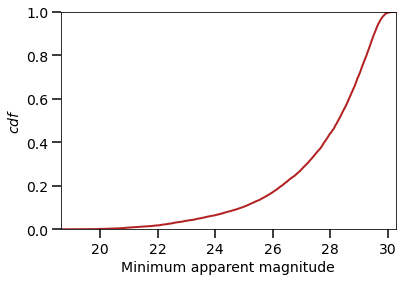

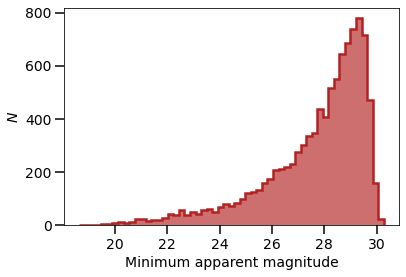

In [14]:
min_mag = np.min(orbits['mag'], axis=1)
plot_cdf(min_mag, xlabel='Minimum apparent magnitude', \
         color='firebrick', name='min_mag_cdf')
plot_hist(min_mag, c='firebrick', label='Minimum apparent magnitude', \
          name='min_mag_hist')

In [15]:
detectable = (orbits['mag'] <= 24)*(orbits['pos_horiz'][:, :, 1] > np.radians(30.))*(orbits['solar_pos_horiz'][:, :, 1] < np.radians(-18.))
detectable = np.any(detectable==True, axis=1)
ndetect = len(detectable[detectable==True])
        
print('Detections: %d' %ndetect)
print('Detection rate: %.3f %%' %(ndetect/NSAMPLES*100))

Detections: 186
Detection rate: 1.860 %


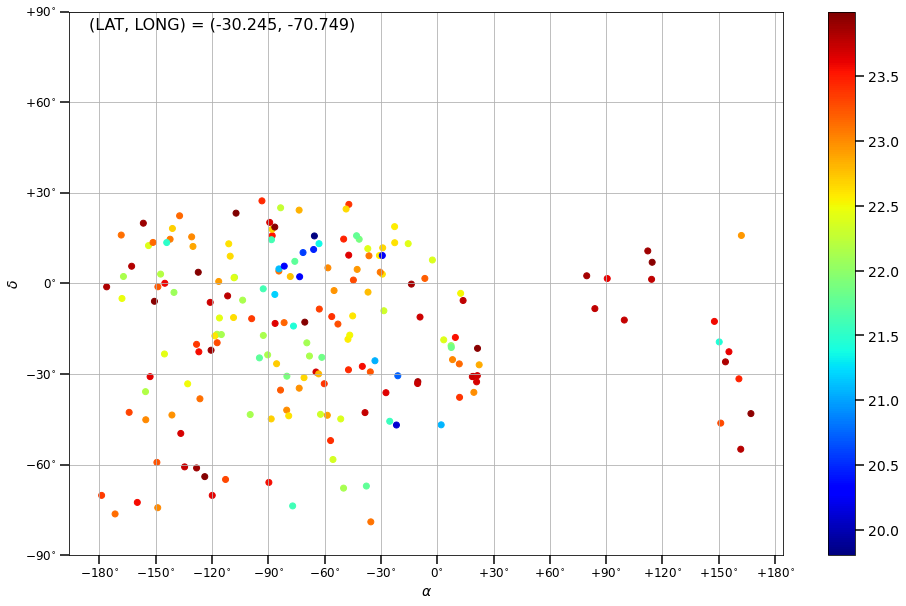

In [16]:
det_pos = []
det_mag = []
for i in range(NSAMPLES):
    det = (orbits['mag'][i] <= 24.)*\
            (orbits['pos_horiz'][i][:, 1] > np.radians(30.))*\
            (orbits['solar_pos_horiz'][i][:, 1] < np.radians(-18.))
    if True in det:
        j = np.where(orbits['mag'][i][det] == np.min(orbits['mag'][i][det]))
        det_pos.append(orbits['pos_eq'][i][det][j])
        det_mag.append(orbits['mag'][i][det][j])
            
det_pos = np.reshape(det_pos, (ndetect, 2))
det_mag = np.reshape(det_mag, ndetect)
    
plt.figure(figsize=(16, 10))
plt.scatter(det_pos[:, 0], det_pos[:, 1], c=det_mag, cmap='jet')

plt.xlabel(r'$\alpha$')
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          fontsize=12)

plt.ylabel(r'$\delta$')
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)
plt.colorbar()

plt.text(-pi-0.1, pi/2-0.1, '(LAT, LONG) = (%.3f, %.3f)' %(np.degrees(LAT), \
            np.degrees(LONG)), fontsize=16)

plt.savefig('figures/detectable_pos.pdf', bbox_inches='tight', dpi=250)
plt.show()

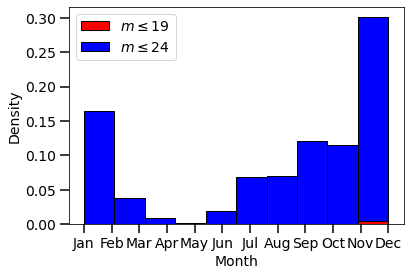

In [17]:
min_mag_month = np.zeros(NSAMPLES)
for i in range(NSAMPLES):
    min_mag_month[i] = orbits['datetime'][i][orbits['mag'][i] == \
                                    min_mag[i]].flatten()[1]

c = ['red', 'blue']
plt.hist([min_mag_month[min_mag <= 19.], min_mag_month[min_mag <= 24.]], \
         stacked=True, color=c, edgecolor='k', density=True, \
        label=[r'$m\leq 19$', r'$m\leq 24$'])

plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', \
                             'May', 'Jun', 'Jul', 'Aug', 'Sep', \
                              'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.savefig('figures/month_detect.pdf', bbox_inches='tight', dpi=250)
plt.show()